In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import getpass
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import itertools
from pydynpd import regression
import statsmodels.formula.api as smf
from scipy.optimize import minimize
pd.set_option('display.max_rows', None)
from linearmodels.panel import PanelOLS
from functools import reduce

In [2]:
# Change working directory and import files
username = getpass.getuser()
if username == 'enqi':
    os.chdir(r"C:\Users\\" + username + "\\Dropbox\env_assignment")
    output_dir = (r"C:\Users\\" + username + "\\Dropbox\Apps\Overleaf\Advanced Environmental Economics Problem Set\\figtab")
elif username == '': # change dir here
    os.chdir(r"C:\Users\\" + username + "\\Dropbox\env_assignment") 
    output_dir = r"C:\Users\\" + username + "\\Dropbox\env_assignment\results"

In [3]:
# Import files
landuse = pd.read_csv('data\land_use_panel.csv')
spatial = gpd.read_file('data\sigpacGrid250.shp')

1. Working with spatial data

In [5]:
# (a) Reclassifying crops based on whether they are irrigated or not
landuse['j'] = landuse['LU'].astype(str) + '_' + landuse['irrigation'].astype(str)
mask = (landuse['LU'] == 'other')
landuse.loc[mask, 'j'] = 'other'

In [6]:
len(landuse)

1317999

In [7]:
mergeddf = spatial.merge(landuse, how='outer', on= 'grid_id', suffixes=('_landuse', '_spatial'), indicator = True) 
# check unmerged: mergeddf[mergeddf['_merge'] == 'both'], unmerged only from spatial data, observations seem to not exist in land use data
mergeddf = mergeddf[mergeddf['_merge'] == 'both']
# check column mergeddf[mergeddf['prov_landuse'] != mergeddf['prov_spatial']]
mergeddf = mergeddf.drop(['prov_landuse','_merge'], axis = 'columns')
mergeddf = mergeddf.rename(columns={'prov_spatial': 'prov'})

In [8]:
# (b) Compute the area of the grid cells (in hectares)
mergeddf['grid_area'].sum()/10000

823.749375

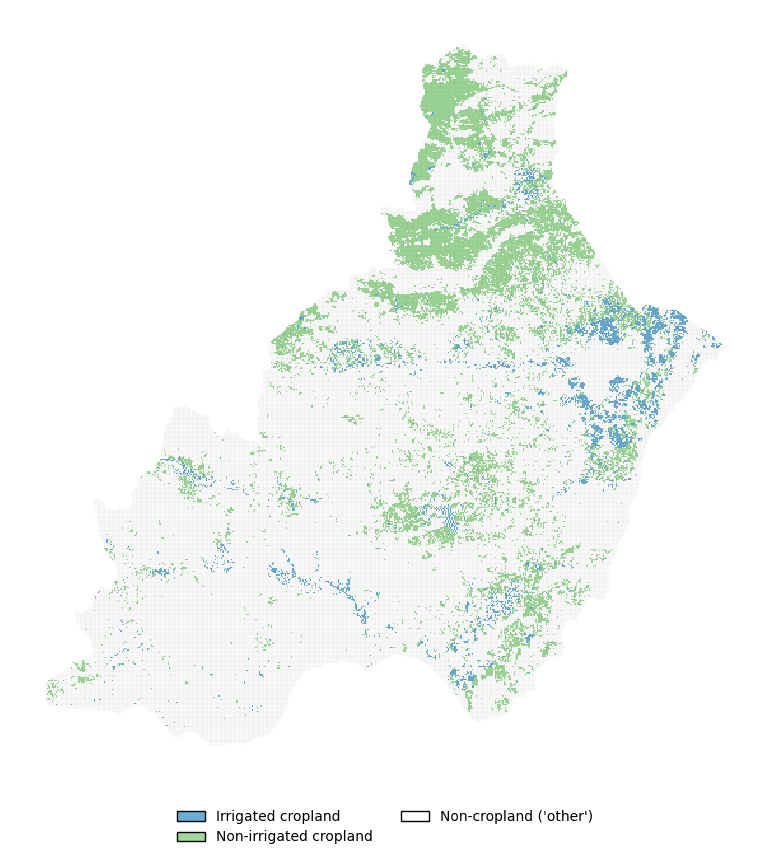

In [9]:
# (c) Show in map the spatial distribution of cropland (irrigated, non-irrigated) in 2021 in the province of Almeria.
# check if all grids have only one irrigation value: mapdata.groupby('grid_id')['LU'].nunique().eq(1).all()
mergeddf['land_type'] = 'non-cropland'
mask_non_irr = mergeddf['j'].astype(str).str.contains('0', na=False)
mask_irr = mergeddf['j'].astype(str).str.contains('1', na=False)
mergeddf.loc[mask_non_irr, 'land_type'] = 'cropland_non_irr'
mergeddf.loc[mask_irr, 'land_type'] = 'cropland_irr'
mapdata = mergeddf[(mergeddf['prov'] == 'Almeria') & (mergeddf['year'] == 2021)]
color_map = {'cropland_irr': '#6baed6', 'cropland_non_irr': '#a1d99b', 'non-cropland': '#ffffff'}
ax = mapdata.plot(
    color=mapdata['land_type'].map(color_map),
    edgecolor='black',
    linewidth=0.01,
    figsize=(10, 10)
)
legend_handles = [
    Patch(facecolor='#6baed6', edgecolor='black', label='Irrigated cropland'),
    Patch(facecolor='#a1d99b', edgecolor='black', label='Non-irrigated cropland'),
    Patch(facecolor='#ffffff', edgecolor='black', label='Non-cropland (\'other\')')
]
ax.legend(
    handles=legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False
)
ax.set_axis_off()
filepath = os.path.join(output_dir, "irrigation_map.png")
plt.savefig(filepath, dpi=300, bbox_inches='tight')
# Check to see if roughly matches figure
# print("Non-cropland: " + str(mergeddf.loc[mergeddf['land_type'] == 'non-cropland', 'grid_area'].sum()))
# print("Irrigated cropland: " + str(mergeddf.loc[mergeddf['land_type'] == 'cropland_irr', 'grid_area'].sum()))
# print("Non-irrigated cropland: " + str(mergeddf.loc[mergeddf['land_type'] == 'cropland_non_irr', 'grid_area'].sum()))

In [10]:
# (d) Descriptive statistics: compute total area by crop (average across all years), plot total area under irrigation over time (aggregate and by crop). 
summstats_bycrop = mergeddf.loc[mergeddf['LU'] != 'other']
summstats_bycrop = summstats_bycrop.groupby(['LU', 'year'])['grid_area'].sum().reset_index()
summstats_bycrop = summstats_bycrop.groupby(['LU'])['grid_area'].mean().reset_index()
summstats_bycrop = summstats_bycrop.rename(columns={'LU': 'Crop',
                                                   'grid_area': 'Mean annual area (in hectares)'})
summstats_bycrop['Crop'] = summstats_bycrop['Crop'].str.capitalize()
summstats_bycrop['Crop'] = pd.Categorical(
    summstats_bycrop['Crop'],
    categories=sorted(summstats_bycrop['Crop'].unique(), key=lambda x: (x == 'Other', x))
)
summstats_bycrop = summstats_bycrop.sort_values('Crop')
latex_table = summstats_bycrop.to_latex(index=False, bold_rows=True)
filepath = os.path.join(output_dir, "1d_i.txt")
with open(filepath, "w") as f:
    f.write(latex_table)
df = mergeddf.groupby(['LU', 'irrigation', 'year'])['grid_area'].sum().reset_index()
df = df[df['irrigation'] == 1.0]
for lu, group in df.groupby('LU'):
    group_sorted = group.sort_values('year')
    plt.plot(group_sorted['year'], group_sorted['grid_area'], marker='o', label=lu.capitalize())
plt.xlabel('Year')
plt.ylabel('Total irrigated area')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()
filepath = os.path.join(output_dir, "1d_ii.png")
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.close()
df = df.groupby(['year'])['grid_area'].sum().reset_index()
plt.plot(df['year'], df['grid_area'], marker='o', color='black', label='Total Area')
plt.xlabel('Year')
plt.ylabel('Total irrigated area')
plt.grid(True)
plt.legend()
plt.tight_layout()
filepath = os.path.join(output_dir, "1d_iii.png")
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.close()

4. Estimation

In [12]:
# (a) Frequency estimator for choice probabilities
mergeddf = mergeddf.sort_values(['grid_id', 'year'])
mergeddf['k'] = mergeddf.groupby('grid_id')['j'].shift(1)
j_list = mergeddf['j'].unique().tolist()
transitions = pd.DataFrame(list(itertools.product(j_list,
                                                 j_list, 
                                                 mergeddf['prov'].unique(), 
                                                 list(range(2018, 2025)))), columns=['j', 'k', 'prov', 'year'])
## Apply smoothing frequency estimator weighting by distance like in Scott (2013)
## Constructing distance matrix
## Note: This step takes a while to run so the distance matrix was stored and the below code was commented out to avoid long runtimes.
# province = spatial.dissolve(by='prov').reset_index()
# province['centroid'] = province.geometry.centroid
# provinces = province['prov'].tolist()
# n = len(provinces)
# distance_matrix = pd.DataFrame(index=provinces, columns=provinces, dtype=float)
# for i, row_i in province.iterrows():
#     for j, row_j in province.iterrows():
#         dist = row_i['centroid'].distance(row_j['centroid'])
#         distance_matrix.loc[row_i['prov'], row_j['prov']] = dist
# distance_matrix.to_csv("distance_matrix.csv")
distance_matrix = pd.read_csv("distance_matrix.csv", index_col=0)
all_provs = pd.Index(sorted(set(transitions['prov']) | set(mergeddf['prov'])))
prov2idx = {prov: i for i, prov in enumerate(all_provs)}
transitions['prov_code'] = transitions['prov'].map(prov2idx)
mergeddf['prov_code'] = mergeddf['prov'].map(prov2idx)
distance_array = distance_matrix.loc[all_provs, all_provs].to_numpy()
grouped = mergeddf.groupby(['k', 'year'])
def compute_smoothed_freq_grouped(transitions, grouped, distance_array):
    from numpy import zeros, float64
    N = len(transitions)
    result = zeros(N, dtype=float64)
    for i in range(N):
        j_star = transitions.iat[i, transitions.columns.get_loc('j')]
        k_star = transitions.iat[i, transitions.columns.get_loc('k')]
        prov_idx = transitions.iat[i, transitions.columns.get_loc('prov_code')]
        year = transitions.iat[i, transitions.columns.get_loc('year')]
        key = (k_star, year)
        if key not in grouped.groups:
            continue
        candidates = grouped.get_group(key)
        cand_prov_idx = candidates['prov_code'].values
        cand_j = candidates['j'].values
        # Spatial weights
        dists = distance_array[prov_idx, cand_prov_idx]
        weights = (1 + dists) ** -2
        # Indicator for j match
        is_j = (cand_j == j_star).astype(float64)
        num = (weights * is_j).sum()
        denom = weights.sum()
        if denom > 0:
            result[i] = num / denom
    return result
transitions['freq'] = compute_smoothed_freq_grouped(transitions, grouped, distance_array)
# Final pass to deal with zero probability estimates
epsilon = 1e-6
transitions.loc[transitions['freq'] == 0, 'freq'] = epsilon

In [13]:
# (b) Province-year returns by crop
#Import files
crops = pd.read_csv('data\cropReturns.csv')
weather = pd.read_csv('data\weatherAnd.csv')
mask = crops['subcrop'].str.contains('irrigated', na=False)
crops.loc[mask, 'crop'] = crops.loc[mask, 'crop'] + '_1'
crops.loc[~mask, 'crop'] = crops.loc[~mask, 'crop'] + '_0'
cropreturns = pd.merge(crops, weather, on=['year', 'prov'], how='outer')
cropreturns = cropreturns.dropna(subset=['yield', 'DD10', 'DD30', 'precipitation', 'year'])
results_list = []
for crop in cropreturns['subcrop'].dropna().unique().tolist():
    cropmodel = cropreturns[(cropreturns['subcrop'] == crop)].copy()
    X = cropmodel[['DD10', 'DD30', 'precipitation', 'year']].copy()
    prov_dummies = pd.get_dummies(cropmodel['prov'], prefix='prov', drop_first=True, dtype=int)
    X['DD10 precip'] = X['DD10'] * X['precipitation']
    X['DD30 precip'] = X['DD30'] * X['precipitation']
    X = sm.add_constant(X)
    X = pd.concat([X, prov_dummies], axis=1)
    y = np.log(cropmodel['yield'])
    model = sm.OLS(y, X)
    ols_returns = model.fit()
    cropmodel['yields_predict'] = np.exp(ols_returns.predict(X))
    results_list.append(cropmodel)
cropreturns = pd.concat(results_list, ignore_index=True)
cropreturns['returns_exp'] = (cropreturns['yields_predict']*cropreturns['predictedPrice'] - cropreturns['cost'] + cropreturns['subsidies']) * cropreturns['area']
cropreturns['returns'] = (cropreturns['yield']*cropreturns['price'] - cropreturns['cost'] + cropreturns['subsidies']) * cropreturns['area']
cropreturns = cropreturns.groupby(['prov', 'year', 'crop'])[['returns', 'returns_exp', 'area']].sum().reset_index()
cropreturns['returns_exp'] = (cropreturns['returns_exp']/cropreturns['area'])*6.25
cropreturns['returns'] = (cropreturns['returns']/cropreturns['area'])*6.25
cropreturns.loc[cropreturns['prov'] == 'Almería', 'prov'] = 'Almeria'
cropreturns.loc[cropreturns['prov'] == 'Cádiz', 'prov'] = 'Cadiz'

In [14]:
# (c) Construct dependent variable
obs = []
beta = 0.9
prov_list = mergeddf['prov'].unique()
years = range(2018, 2024)

for k in j_list:
    for j in j_list:
        a_list = [x for x in j_list if x != j]
        for a in a_list:
            for J in j_list:
                for prov in prov_list:
                    for year in years:
                        # Transition frequencies
                        pak = transitions[(transitions['k'] == k) & (transitions['j'] == a) & (transitions['year'] == year) & (transitions['prov'] == prov)]['freq'] # CCP of transitioning from land use type k to land use type a in year t
                        pjk = transitions[(transitions['k'] == k) & (transitions['j'] == j) & (transitions['year'] == year) & (transitions['prov'] == prov)]['freq'] # CCP of transitioning from land use type k to land use type j in year t
                        pJa = transitions[(transitions['k'] == a) & (transitions['j'] == J) & (transitions['year'] == year+1) & (transitions['prov'] == prov)]['freq'] # CCP of transitioning from land use type a to land use type J in year t+1
                        pJj = transitions[(transitions['k'] == j) & (transitions['j'] == J) & (transitions['year'] == year+1) & (transitions['prov'] == prov)]['freq'] # CCP of transitioning from land use type j to land use type J in year t+1
    
                        pak = pak.values[0] if len(pak) > 0 else np.nan # "else" condition should never be reached in the transition matrix, this is just a safety measure
                        pjk = pjk.values[0] if len(pjk) > 0 else np.nan
                        pJa = pJa.values[0] if len(pJa) > 0 else np.nan
                        pJj = pJj.values[0] if len(pJj) > 0 else np.nan
    
                        if np.isnan([pak, pjk, pJa, pJj]).any():
                            Y_val = np.nan
                        else:
                            Y_val = np.log(pak / pjk) + beta * np.log(pJa / pJj)
    
                        # Crop returns (handle 'Other' special case)
                        if j == "other":
                            rj = 350
                        else:
                            rj_vals = cropreturns[(cropreturns['crop'] == j) & (cropreturns['prov'] == prov) & (cropreturns['year'] == year)]['returns_exp']
                            rj = rj_vals.values[0] if len(rj_vals) > 0 else np.nan
    
                        if a == "other":
                            ra = 350
                        else:
                            ra_vals = cropreturns[(cropreturns['crop'] == a) & (cropreturns['prov'] == prov) & (cropreturns['year'] == year)]['returns_exp']
                            ra = ra_vals.values[0] if len(ra_vals) > 0 else np.nan
                        returns = rj - ra if not np.isnan([rj, ra]).any() else np.nan
    
                        # Append to list
                        obs.append({
                            'k': k,
                            'j': j,
                            'a': a,
                            'J': J,
                            'prov': prov,
                            't': year,
                            'Y': Y_val,
                            'DeltaR': returns,
                        })

# Construct DataFrame and compute lags/deltas
panel_df = pd.DataFrame(obs)
panel_df = panel_df.sort_values(['k', 'j', 'a', 'J', 'prov', 't'])
panel_df['Yt'] = panel_df.groupby(['k', 'j', 'a', 'J', 'prov'])['Y'].shift(1)
panel_df['DeltaRt'] = panel_df.groupby(['k', 'j', 'a', 'J', 'prov'])['DeltaR'].shift(1)
panel_df['Ydiff'] = panel_df['Y'] - panel_df['Yt']
panel_df['DeltaRdiff'] = panel_df['DeltaR'] - panel_df['DeltaRt']

In [15]:
# (d) GMM estimation
# Defining the GMM function
def gmm_objective(theta, y_diff, r_diff, Z, W):
    u = y_diff - theta * r_diff
    moments = Z.T @ u
    return moments.T @ W @ moments

def jacobian(theta, r_diff, Z):
    return -Z.T @ r_diff

def two_step_gmm(y_diff, r_diff, Z):
    if Z.ndim == 1:
        Z = Z[:, None]
    n = len(y_diff)
    W = np.eye(Z.shape[1])

    def obj(theta):
        return gmm_objective(theta, y_diff, r_diff, Z, W)

    res1 = minimize(obj, x0=0.1)
    theta1 = res1.x[0]

    u1 = y_diff - theta1 * r_diff
    S = (Z * u1[:, None]).T @ (Z * u1[:, None]) / n
    W_opt = np.linalg.pinv(S)

    def obj2(theta):
        return gmm_objective(theta, y_diff, r_diff, Z, W_opt)
    theta_vals = np.linspace(-10, 10, 400)
    gmm_vals = [gmm_objective(t, y_diff, r_diff, Z, np.eye(Z.shape[1])) for t in theta_vals]

    res2 = minimize(obj2, x0=theta1)
    theta2 = res2.x[0]
    D = jacobian(theta2, r_diff, Z).reshape(-1, 1)
    DW = D.T @ W_opt
    middle = DW @ S @ DW.T
    inv_term = np.linalg.inv(DW @ D)
    var_theta = inv_term @ middle @ inv_term
    se_theta = np.sqrt(var_theta).flatten()[0]

    return theta2, se_theta
# Estimation
panel_df = panel_df.dropna(subset=['Ydiff', 'DeltaRdiff', 'DeltaRt'])
y_diff = panel_df['Ydiff'].values
r_diff = panel_df['DeltaRdiff'].values
Z = panel_df['DeltaRt'].values
theta_hat, se_theta = two_step_gmm(y_diff, r_diff, Z)
print(f"Estimate: {theta_hat:.4f}  Std. Error: {se_theta:.4f}")

Estimate: 0.0003  Std. Error: 0.0000


In [16]:
# (f) Recover estimated switching costs
# First, construct dataframe of estimated switching costs
panel_df['LHS'] = panel_df['Yt'] - theta_hat*panel_df['DeltaRt']
alpha = []
for k in j_list:
    for j in j_list:
        a_list = [x for x in j_list if x != j]
        for a in a_list:
            for J in j_list:
                df_est = panel_df[(panel_df['k'] == k) & (panel_df['j'] == j) & (panel_df['a'] == a) & (panel_df['J'] == J)]
                if len(df_est) == 0:
                    break
                else:
                    y = df_est['LHS']
                    X = np.ones((len(y), 1))
                    model = sm.OLS(y, X).fit()
                    intercept = model.params['const']
                    alpha.append({
                            'k': k,
                            'j': j,
                            'a': a,
                            'J': J,
                            'costs': intercept,
                        })
cost_df = pd.DataFrame(alpha)

In [17]:
## Switching from j or a to J' == 'other' incurs switching cost theta_j + theta_kj - theta_a - theta_ka (theta_jJ' and theta_aJ' cancel out)
# Take j,k,a,J - j,k,a,J' where J' = other => get term (-beta theta_jJ + beta theta_aJ)
for k in j_list:
    for j in j_list:
        for a in [x for x in j_list if x != j]:
            mask_other = (cost_df['k'] == k) & (cost_df['j'] == j) & (cost_df['a'] == a) & (cost_df['J'] == 'other')
            if cost_df[mask_other].empty:
                continue
            p1cost = cost_df.loc[mask_other, 'costs'].values[0]
            mask_all = (cost_df['k'] == k) & (cost_df['j'] == j) & (cost_df['a'] == a) & (cost_df['J'] != 'other')
            cost_df.loc[mask_all, "beta(theta_aJ - theta_jJ)"] = cost_df.loc[mask_all, 'costs'] - p1cost
# When J = j, theta_jJ = 0 => use this to recover and store theta_aJ
cost_df.loc[(cost_df['j'] == cost_df['J']), 'beta(theta_aJ)'] = cost_df.loc[(cost_df['j'] == cost_df['J']), 'beta(theta_aJ - theta_jJ)']
theta_df = cost_df[['a', 'J', 'beta(theta_aJ)']].dropna(subset=['beta(theta_aJ)']).copy()
theta_df['beta(theta_aJ)'] = theta_df['beta(theta_aJ)'] / beta
theta_df = theta_df.rename(columns={
    'a': 'origin_crop',
    'J': 'destination_crop',
    'beta(theta_aJ)': 'switching_cost'
})
theta_df = (theta_df.groupby(['origin_crop', 'destination_crop'], as_index=False)['switching_cost'].mean()) # checked that variation is at the 15th or so decimal place level
rows = pd.DataFrame([
    {'origin_crop': k, 'destination_crop': k, 'switching_cost': 0.0}
    for k in j_list
])
other_rows = pd.DataFrame([
    {'origin_crop': k, 'destination_crop': 'other', 'switching_cost': 0.0}
    for k in j_list
])
theta_df = pd.concat([theta_df, rows, other_rows], ignore_index=True)

In [18]:
# (g)
# Examining whether yields are larger than predicted based on weather variables (indicating possibility of adaptation by irrigation)
yields_predict = pd.concat(results_list, ignore_index=True)
cols = ['year', 'prov', 'subcrop', 'yields_predict']
yields_predict = yields_predict[cols]
crops['crop'] = crops['crop'].str.replace('_0', '')
crops['crop'] = crops['crop'].str.replace('_1', '')
yields = pd.merge(crops, yields_predict, on=['year', 'prov', 'subcrop'], how='right')
yields = yields.groupby('crop', as_index=False).agg({'yield': 'sum',
                                                         'yields_predict': 'sum'})
yields['benefits_from_adaptation'] = yields['yield'] - yields['yields_predict']
# Examining switching cost estimates and distinguishing between crop switching and irrigation switching costs
new_theta_df = theta_df[theta_df['origin_crop'] != theta_df['destination_crop']].reset_index(drop=True)
new_theta_df['origin_crop_family'] = new_theta_df['origin_crop'].str.replace(r'_\d$', '', regex=True)
new_theta_df['destination_crop_family'] = new_theta_df['destination_crop'].str.replace(r'_\d$', '', regex=True)
new_theta_df['irrigation_switching_cost'] = np.where(
    (new_theta_df['origin_crop_family'] == new_theta_df['destination_crop_family']) &
    (new_theta_df['origin_crop'] != new_theta_df['destination_crop']), # should have been dropped, just to be sure
    new_theta_df['switching_cost'],
    pd.NA
)
new_theta_df['crop_switching_cost'] = np.where(
    (new_theta_df['origin_crop_family'] != new_theta_df['destination_crop_family']) &
    (new_theta_df['origin_crop'].str[-1] == new_theta_df['destination_crop'].str[-1]),
    new_theta_df['switching_cost'],
    pd.NA
)
mean_irrigation = new_theta_df['irrigation_switching_cost'].dropna().mean()
mean_crop = new_theta_df['crop_switching_cost'].dropna().mean()
print(f"Mean irrigation switching cost: {mean_irrigation}")
print(f"Mean crop switching cost: {mean_crop}")

Mean irrigation switching cost: -8.763006246897183
Mean crop switching cost: -7.405164755331003


In [19]:
# (h)i) Myopic agents: beta = 0
obs = []
prov_list = mergeddf['prov'].unique()
years = range(2018, 2024)
for k in j_list:
    for j in j_list:
        a_list = [x for x in j_list if x != j]
        for a in a_list:
            for prov in prov_list:
                for year in years:
                    pak = transitions[(transitions['k'] == k) & (transitions['j'] == a) & (transitions['year'] == year) & (transitions['prov'] == prov)]['freq']
                    pjk = transitions[(transitions['k'] == k) & (transitions['j'] == j) & (transitions['year'] == year) & (transitions['prov'] == prov)]['freq']
                        
                    pak = pak.values[0] if len(pak) > 0 else np.nan
                    pjk = pjk.values[0] if len(pjk) > 0 else np.nan

                    if np.isnan([pak, pjk]).any():
                        Y_val = np.nan
                    else:
                        Y_val = np.log(pak / pjk)

                    if j == "other":
                        rj = 350
                    else:
                        rj_vals = cropreturns[(cropreturns['crop'] == j) & (cropreturns['prov'] == prov) & (cropreturns['year'] == year)]['returns_exp']
                        rj = rj_vals.values[0] if len(rj_vals) > 0 else np.nan

                    if a == "other":
                        ra = 350
                    else:
                        ra_vals = cropreturns[(cropreturns['crop'] == a) & (cropreturns['prov'] == prov) & (cropreturns['year'] == year)]['returns_exp']
                        ra = ra_vals.values[0] if len(ra_vals) > 0 else np.nan
                    returns = rj - ra if not np.isnan([rj, ra]).any() else np.nan

                    # Append to list
                    obs.append({
                        'k': k,
                        'j': j,
                        'a': a,
                        'prov': prov,
                        't': year,
                        'Y': Y_val,
                        'DeltaR': returns,
                    })
myopic_df = pd.DataFrame(obs)
myopic_df = myopic_df.sort_values(['k', 'j', 'a', 'prov', 't'])
myopic_df['Yt'] = myopic_df.groupby(['k', 'j', 'a', 'prov'])['Y'].shift(1)
myopic_df['DeltaRt'] = myopic_df.groupby(['k', 'j', 'a', 'prov'])['DeltaR'].shift(1)
myopic_df['Ydiff'] = myopic_df['Y'] - myopic_df['Yt']
myopic_df['DeltaRdiff'] = myopic_df['DeltaR'] - myopic_df['DeltaRt']
myopic_df = myopic_df.dropna(subset=['Ydiff', 'DeltaRdiff', 'DeltaRt'])
# Run GMM
y_diff = myopic_df['Ydiff'].values
r_diff = myopic_df['DeltaRdiff'].values
Z = myopic_df['DeltaRt'].values
theta_hat, se_theta = two_step_gmm(y_diff, r_diff, Z)
print(f"Estimate: {theta_hat:.4f}  Std. Error: {se_theta:.4f}")

Estimate: -0.0001  Std. Error: 0.0000


In [20]:
# (h)ii) Removing dynamics, i.e. no state dependence
# Re-constructing frequency estimator (static choice probabilities instead of transitions)
total_counts = mergeddf.groupby(['year', 'prov']).size().reset_index(name='total')
epsilon = 1e-6
dfs = []
for j in j_list:
    choice_counts = mergeddf[mergeddf['j'] == j].groupby(['year', 'prov']).size().reset_index(name=j)
    newdf = pd.merge(total_counts, choice_counts, on=['year', 'prov'], how='left')
    newdf[j] = newdf[j].fillna(0)
    newdf[j] = newdf[j] / newdf['total']
    newdf[j] = newdf[j].replace(0, epsilon)
    dfs.append(newdf[['year', 'prov', j]])
prob = reduce(lambda left, right: pd.merge(left, right, on=['year', 'prov']), dfs)
obs = []
prov_list = mergeddf['prov'].unique()
years = range(2018, 2024)
for prov in prov_list:
    for year in years:
        for j in j_list:
            a_list = [x for x in j_list if x != j]
            for a in a_list:
                pj = prob[(prob['year'] == year) & (prob['prov'] == prov)][j]
                pa = prob[(prob['year'] == year) & (prob['prov'] == prov)][a]
                pj = pj.values[0] if len(pj) > 0 else np.nan
                pa = pa.values[0] if len(pa) > 0 else np.nan
                
                if np.isnan([pj,pa]).any():
                    Y_val = np.nan
                else:
                    Y_val = np.log(pa / pj)

                if j == "other":
                    rj = 350
                else:
                    rj_vals = cropreturns[(cropreturns['crop'] == j) & (cropreturns['prov'] == prov) & (cropreturns['year'] == year)]['returns_exp']
                    rj = rj_vals.values[0] if len(rj_vals) > 0 else np.nan

                if a == "other":
                    ra = 350
                else:
                    ra_vals = cropreturns[(cropreturns['crop'] == a) & (cropreturns['prov'] == prov) & (cropreturns['year'] == year)]['returns_exp']
                    ra = ra_vals.values[0] if len(ra_vals) > 0 else np.nan
                returns = rj - ra if not np.isnan([rj, ra]).any() else np.nan

                        # Append to list
                obs.append({'j': j,
                            'a': a,
                            'prov': prov,
                            't': year,
                            'Y': Y_val,
                            'DeltaR': returns,
                })
static_df = pd.DataFrame(obs)
static_df = static_df.sort_values(['j', 'a', 'prov', 't'])
static_df['Yt'] = static_df.groupby(['j', 'a', 'prov'])['Y'].shift(1)
static_df['DeltaRt'] = static_df.groupby(['j', 'a', 'prov'])['DeltaR'].shift(1)
static_df['Ydiff'] = static_df['Y'] - static_df['Yt']
static_df['DeltaRdiff'] = static_df['DeltaR'] - static_df['DeltaRt']
static_df = static_df.dropna(subset=['Ydiff', 'DeltaRdiff', 'DeltaRt'])
# Run GMM
y_diff = static_df['Ydiff'].values
r_diff = static_df['DeltaRdiff'].values
Z = static_df['DeltaRt'].values
theta_hat, se_theta = two_step_gmm(y_diff, r_diff, Z)
print(f"Estimate: {theta_hat:.4f}  Std. Error: {se_theta:.4f}")

Estimate: 0.0000  Std. Error: 0.0000
